In [73]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import keras as ke
from keras import layers as lr


In [74]:
def mygenerator():
    gModel=ke.models.Sequential()
    
    gModel.add(lr.Dense(units=256,input_dim=100))
    gModel.add(lr.LeakyReLU(0.3))
    gModel.add(lr.Dense(units=512))
    gModel.add(lr.LeakyReLU(0.3))
    gModel.add(lr.Dense(units=1024))
    gModel.add(lr.LeakyReLU(0.2))
    
    gModel.add(lr.Dense(units=784, activation='tanh'))
    
    gModel.compile(loss='binary_crossentropy', optimizer=ke.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    return gModel

In [75]:
def mydiscriminator():
    dModel=ke.models.Sequential()

    dModel.add(lr.Dense(1024,input_dim=784))
    dModel.add(lr.LeakyReLU(0.2))
    dModel.add(lr.Dropout(0.3))   
    dModel.add(lr.Dense(512))
    dModel.add(lr.LeakyReLU(0.2))
    dModel.add(lr.Dropout(0.3))
    dModel.add(lr.Dense(256))
    dModel.add(lr.LeakyReLU(0.3))
    dModel.add(lr.Dropout(0.3))
    dModel.add(lr.Dense(128))
    dModel.add(lr.LeakyReLU(0.3))
    
    dModel.add(lr.Dense(1, activation='sigmoid'))
    
    dModel.compile(loss='binary_crossentropy', optimizer=ke.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    return dModel

In [76]:

g=mygenerator()
d=mydiscriminator()

d.trainable = False
inputs = lr.Input(shape=(100, ))
temp = g(inputs)
outputs = d(temp)
final = ke.models.Model(inputs, outputs)

final.compile(loss='binary_crossentropy', optimizer=ke.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
final.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_20 (Sequential)  (None, 784)               1486352   
                                                                 
 sequential_21 (Sequential)  (None, 1)                 1492993   
                                                                 
Total params: 2,979,345
Trainable params: 1,486,352
Non-trainable params: 1,492,993
_________________________________________________________________


In [77]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
# flatten images 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[1])


In [78]:

def generateNoiseVectors(images=128):
    vector = np.random.normal(0, 1, [images, 100])
    return vector

def generateImagesFromNoise(images=128):
    noiseVectors = generateNoiseVectors(images)
    return g.predict(noiseVectors)

def visualizeGenerator(i):
    images = generateImagesFromNoise(50).reshape(50,28,28)
    plt.figure(figsize=(20,10))

    plt.title(f"Generator performance at stage: {i}")
    for i in range(images.shape[0]):
        plt.subplot(5, 10, i+1) 
        plt.imshow(images[i], interpolation='nearest')
    plt.tight_layout()
    # plt.show()

# epochs
for i in range(100):
    # batch
    for _ in range(128):
        gImages = generateImagesFromNoise()

        actualImages = x_train[np.random.randint(
            low=0, high=x_train.shape[0], size=128)]

        actualImagesLabels = np.array(
            [0.99 for _ in range(128)])   # high for actual
        generatedImagesLabels = np.array(
            [0 for _ in range(128)])   # low for fake

        # fix generator , update descriminator
        d.trainable = True
        d.train_on_batch(np.concatenate(
            [actualImages, gImages]),
            np.concatenate([actualImagesLabels, generatedImagesLabels])
        )

        # fix descriminator , update generator with fake data
        d.trainable = False
        final.train_on_batch(generateNoiseVectors(), np.ones(128))
#     if(i%10==0):
#         visualizeGenerator(i)

4/4 [==============================] - 0s 4ms/step


In [79]:
model_json = g.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
g.save_weights("generator.h5")

4/4 [==============================] - 0s 4ms/step


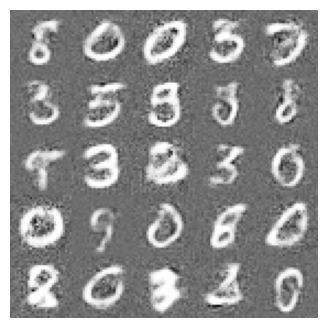

In [80]:
# Generate images
np.random.seed(504)
h = w = 28
num_gen = 25

generated_images = generateImagesFromNoise()

# plot of generation
n = np.sqrt(num_gen).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = generated_images[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.show()